In [1]:
import numpy as np
import pandas as pd

# Import the datasets
amazon_term_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Amazon-Term_reduced.csv')
amazon_2gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Amazon-Bigram_reduced.csv')
amazon_3gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Amazon-Trigram_reduced.csv')
amazon_4gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Amazon-4-gram_reduced.csv')

In [2]:
# Term training data and labels
X_train_term = amazon_term_training.iloc[:, :-1].values
y_train_term = amazon_term_training.iloc[:, -1].values

# Bigram training data and labels
X_train_2gram = amazon_2gram_training.iloc[:, :-1].values
y_train_2gram = amazon_2gram_training.iloc[:, -1].values

# 3gram training data and labels
X_train_3gram = amazon_3gram_training.iloc[:, :-1].values
y_train_3gram = amazon_3gram_training.iloc[:, -1].values

# 4gram training data and labels
X_train_4gram = amazon_4gram_training.iloc[:, :-1].values
y_train_4gram = amazon_4gram_training.iloc[:, -1].values

In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Term - Best hyperparameters:  {'max_depth': 50, 'n_estimators': 10}
Term - Average accuracy: 0.662 (+- 0.047)
2-gram - Best hyperparameters:  {'max_depth': 50, 'n_estimators': 100}
2-gram - Average accuracy: 0.715 (+- 0.061)
3-gram - Best hyperparameters:  {'max_depth': 50, 'n_estimators': 100}
3-gram - Average accuracy: 0.676 (+- 0.060)
4-gram - Best hyperparameters:  {'max_depth': 10, 'n_estimators': 1000}
4-gram - Average accuracy: 0.662 (+- 0.050)


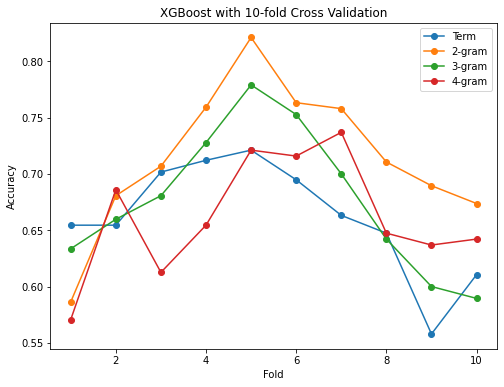


Classification Report (Term):
              precision    recall  f1-score      support
0              0.584173  0.533509  0.557692   761.000000
1              0.706369  0.747157  0.726190  1143.000000
accuracy       0.661765  0.661765  0.661765     0.661765
macro avg      0.645271  0.640333  0.641941  1904.000000
weighted avg   0.657529  0.661765  0.658844  1904.000000

Classification Report (2-gram):
              precision    recall  f1-score      support
0              0.657061  0.599212  0.626804   761.000000
1              0.747934  0.791776  0.769231  1143.000000
accuracy       0.714811  0.714811  0.714811     0.714811
macro avg      0.702497  0.695494  0.698017  1904.000000
weighted avg   0.711613  0.714811  0.712305  1904.000000

Classification Report (3-gram):
              precision    recall  f1-score      support
0              0.609023  0.532194  0.568022   761.000000
1              0.712672  0.772528  0.741394  1143.000000
accuracy       0.676471  0.676471  0.676471     

In [4]:
# Adjust pandas display options
pd.options.display.max_columns = None
pd.options.display.width = None

def evaluate_model(n_gram, X_train, y_train, ax):
    # Define the parameter grid for the grid search
    param_grid = {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 10, 50, 100],
    }

    # Define the XGBoost classifier model
    model = xgb.XGBClassifier()

    # Perform the grid search
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=k, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print(f"{n_gram} - Best hyperparameters: ", grid_search.best_params_)

    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Compute cross-validated scores and predictions
    scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=k)
    print(f'{n_gram} - Average accuracy: %.3f (+- %.3f)' % (np.mean(scores), np.std(scores)))

    ax.plot(range(1, k+1), scores, '-o', label=n_gram)

    y_pred = cross_val_predict(best_model, X_train, y_train, cv=k)
    report = classification_report(y_train, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df

k = 10
fig, ax = plt.subplots(figsize=(8, 6))

n_grams = ['Term', '2-gram', '3-gram', '4-gram']
X_train_list = [X_train_term, X_train_2gram, X_train_3gram, X_train_4gram]
y_train_list = [y_train_term, y_train_2gram, y_train_3gram, y_train_4gram]

reports = []
for n_gram, X_train, y_train in zip(n_grams, X_train_list, y_train_list):
    report_df = evaluate_model(n_gram, X_train, y_train, ax)
    reports.append(report_df)

ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title(f'XGBoost with {k}-fold Cross Validation')
ax.legend()
plt.show()

# Print classification reports
for n_gram, report_df in zip(n_grams, reports):
    print(f'\nClassification Report ({n_gram}):')
    print(report_df)
